## 1. Import & cấu hình I/O

In [1]:
# !pip install networkx pandas numpy matplotlib scipy tqdm

import os, math, json, random
from pathlib import Path
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import spearmanr

# Thư mục I/O
DATA_DIR = Path("Threads_Dataset")     # chứa posts.csv, users.csv (xem Cell 2)
OUT_DIR  = Path("output")   # nơi lưu CSV/ảnh kết quả
OUT_DIR.mkdir(exist_ok=True, parents=True)

# Đặt seed để reproducible
random.seed(42); np.random.seed(42)
plt.rcParams["figure.figsize"] = (8,5)


## 2. Đọc dữ liệu & chuẩn hóa cột

In [2]:
users = pd.read_csv(DATA_DIR/"users.csv")   # link_in_bio, biography, n_followers, user_name, user_url, name
posts = pd.read_csv(DATA_DIR/"posts.csv")   # media, n_likes, user_url, timestamp, post_url, caption_text, parent_url

# Chuẩn hóa kiểu dữ liệu tối thiểu
for col in ["user_url", "post_url", "parent_url"]:
    if col in posts.columns:
        posts[col] = posts[col].astype(str).str.strip()

users["user_url"]  = users["user_url"].astype(str).str.strip()
users["user_name"] = users.get("user_name", pd.Series(index=users.index, dtype=str)).astype(str)
users["name"]      = users.get("name", pd.Series(index=users.index, dtype=str)).astype(str)

# Giữ chỉ những post có tác giả là user nằm trong users.csv
valid_users = set(users["user_url"])
posts = posts[posts["user_url"].isin(valid_users)].copy()

# Map: post_url -> author_user_url (để suy ra tác giả của parent_url)
post_to_author = posts.dropna(subset=["post_url"]) \
                      .drop_duplicates(subset=["post_url"]) \
                      .set_index("post_url")["user_url"].to_dict()

print(f"users: {len(users):,} | posts: {len(posts):,} | unique posts: {len(post_to_author):,}")


users: 55,393 | posts: 129,028 | unique posts: 129,028


## 3. Dựng đồ thị T (DiGraph)

In [3]:
G = nx.DiGraph()

# Thêm nút = tất cả user_url trong users.csv để giữ nhãn & follower counts
G.add_nodes_from(valid_users)

# Xây cạnh: commenter (child_author) -> parent_author
edge_weights = {}
rows = posts.dropna(subset=["parent_url"]).copy()

for _, r in rows.iterrows():
    child_author  = r["user_url"]         # người viết post/comment hiện tại
    parent_link   = r["parent_url"]       # URL của post cha
    parent_author = post_to_author.get(parent_link)

    if not parent_author:    # parent_url không tìm thấy tác giả → bỏ
        continue
    if child_author == parent_author:     # self-loop → bỏ
        continue

    key = (child_author, parent_author)
    edge_weights[key] = edge_weights.get(key, 0) + 1

# Nạp vào graph
for (u, v), w in edge_weights.items():
    G.add_edge(u, v, weight=float(w))

print(f"Directed? {G.is_directed()} | |V|={G.number_of_nodes():,} | |E|={G.number_of_edges():,}")


Directed? True | |V|=55,393 | |E|=89,327


## 4. Các thuộc tính cơ bản của mạng T

### 4.1. Thành phần liên thông lớn nhất (yếu) 

In [4]:
# Lấy WCC lớn nhất (đồ thị có hướng) và bản undirected để tái dùng
if isinstance(G, nx.DiGraph):
    comps = list(nx.weakly_connected_components(G))
    lcc_nodes = max(comps, key=len) if comps else set()
    G_wcc = G.subgraph(lcc_nodes).copy()
else:
    comps = list(nx.connected_components(G))
    lcc_nodes = max(comps, key=len) if comps else set()
    G_wcc = G.subgraph(lcc_nodes).copy()

GU = G_wcc.to_undirected()

# Tiện in nhanh kích thước
print(f"Max weakly CC size: {len(G_wcc):,}, undirected nodes (same) = {GU.number_of_nodes():,}")


Max weakly CC size: 54,257, undirected nodes (same) = 54,257


### 4.2. Density

In [5]:
density = nx.density(G)
print("Density:", density)
pd.DataFrame([["Density", density]], columns=["metric","value"]).to_csv(OUT_DIR/"metric_density.csv", index=False)

Density: 2.9112588112192357e-05


### 4.3.Average clustering coefficient (trên GU)

In [6]:
try:
    avg_clust = nx.average_clustering(GU)
except Exception:
    avg_clust = float("nan")

print("Average clustering coefficient:", avg_clust)
pd.DataFrame([["Average clustering coefficient", avg_clust]],
             columns=["metric","value"]).to_csv(OUT_DIR/"metric_avg_clustering.csv", index=False)


Average clustering coefficient: 0.00622120330015176


### 4.4. Average shortest path length (trên GU) với fallback xấp xỉ

In [7]:
import math, random
asp = float("nan")
try:
    asp = nx.average_shortest_path_length(GU)
except Exception:
    sample = min(len(GU), int(math.sqrt(len(GU))) + 1)
    seeds = random.sample(list(GU.nodes()), sample) if len(GU)>0 else []
    dists = []
    for s in seeds:
        lengths = nx.single_source_shortest_path_length(GU, s)
        if lengths:
            dists.append(np.mean(list(lengths.values())))
    if dists:
        asp = float(np.mean(dists))

print("Average shortest path (approx):", asp)
pd.DataFrame([["Average shortest path (approx)", asp]],
             columns=["metric","value"]).to_csv(OUT_DIR/"metric_avg_shortest_path.csv", index=False)


KeyboardInterrupt: 

## 4.5. Diameter (trên GU) với fallback xấp xỉ

In [ ]:
diam = float("nan")
try:
    diam = nx.diameter(GU)
except Exception:
    sample = min(len(GU), int(math.sqrt(len(GU))) + 1)
    seeds = random.sample(list(GU.nodes()), sample) if len(GU)>0 else []
    eccs = []
    for s in seeds:
        lengths = nx.single_source_shortest_path_length(GU, s)
        if lengths:
            eccs.append(max(lengths.values()))
    if eccs:
        diam = int(np.max(eccs))

print("Diameter (approx):", diam)
pd.DataFrame([["Diameter (approx)", diam]],
             columns=["metric","value"]).to_csv(OUT_DIR/"metric_diameter.csv", index=False)


Diameter (approx): 14


## 4.6. Average indegree / outdegree

In [ ]:
indeg_avg  = np.mean([d for _, d in G.in_degree()])  if G.number_of_nodes() else float("nan")
outdeg_avg = np.mean([d for _, d in G.out_degree()]) if G.number_of_nodes() else float("nan")

print("Average indegree:", indeg_avg)
print("Average outdegree:", outdeg_avg)

pd.DataFrame([
    ["Average indegree", indeg_avg],
    ["Average outdegree", outdeg_avg],
], columns=["metric","value"]).to_csv(OUT_DIR/"metric_avg_degrees.csv", index=False)


Average indegree: 1.612604480710559
Average outdegree: 1.612604480710559


## 4.7. Assortativity (indegree & outdegree)

In [ ]:
try:
    indeg_assort = nx.degree_assortativity_coefficient(G, x="in", y="in")
except Exception:
    indeg_assort = float("nan")

try:
    outdeg_assort = nx.degree_assortativity_coefficient(G, x="out", y="out")
except Exception:
    outdeg_assort = float("nan")

print("Indegree assortativity:", indeg_assort)
print("Outdegree assortativity:", outdeg_assort)

pd.DataFrame([
    ["Indegree assortativity", indeg_assort],
    ["Outdegree assortativity", outdeg_assort],
], columns=["metric","value"]).to_csv(OUT_DIR/"metric_assortativity.csv", index=False)


Indegree assortativity: -0.024030081059292777
Outdegree assortativity: 0.09440445232593103


> Các đỉnh “nổi tiếng” (được nhiều đỉnh khác trỏ tới) hơi có xu hướng được liên kết bởi các đỉnh “ít nổi tiếng” hơn.
> Không thấy hiện tượng “người nổi tiếng follow người nổi tiếng” mạnh.
-> Mạng gần như trung tính
> 
> Các đỉnh có nhiều outgoing edges (out-degree cao) hơi có xu hướng trỏ tới các đỉnh cũng có nhiều outgoing edges.
> Người “tích cực kết nối/phát tán” thường nói chuyện, liên kết, hoặc follow với những người cũng “tích cực” tương tự.
-> M0ạng có xu hướng assortative nhẹ theo “mức độ hoạt động phát ra”.

## 4.8. Kích thước WCC lớn nhất (để đối chiếu bảng)

In [ ]:
max_wcc_size = len(G_wcc)
print("Maximum connected component’s size (weak):", max_wcc_size)
pd.DataFrame([["Maximum connected component’s size (weak)", max_wcc_size]],
             columns=["metric","value"]).to_csv(OUT_DIR/"metric_max_wcc_size.csv", index=False)


Maximum connected component’s size (weak): 54257


## Phân phối centralities

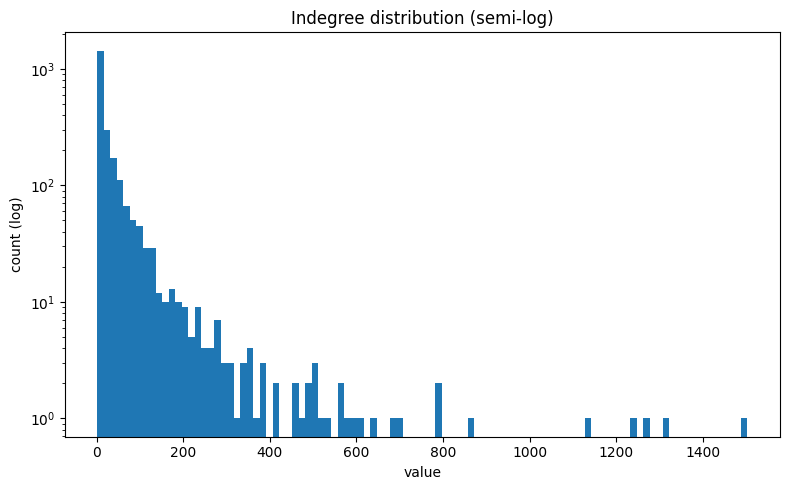

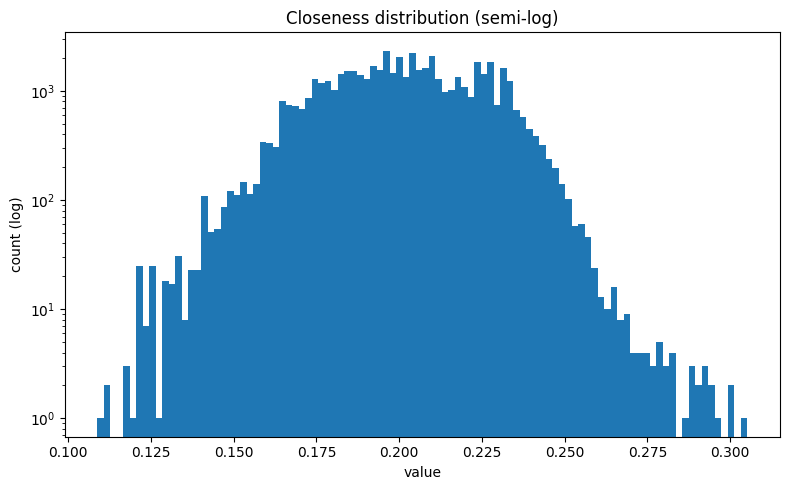

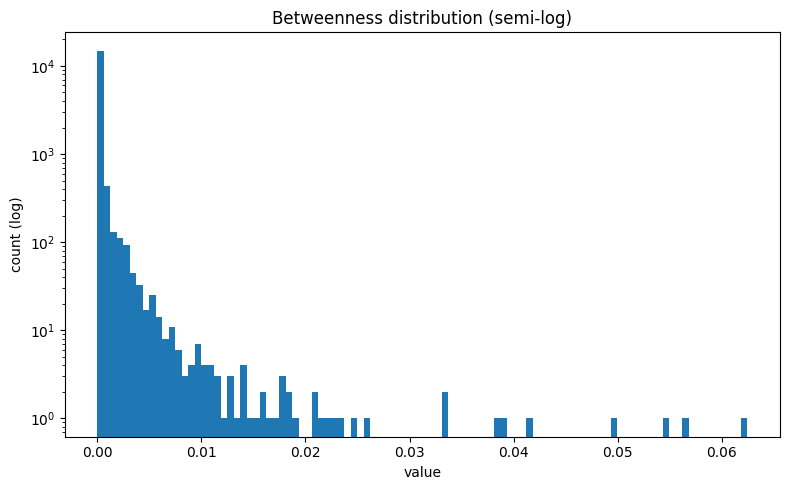

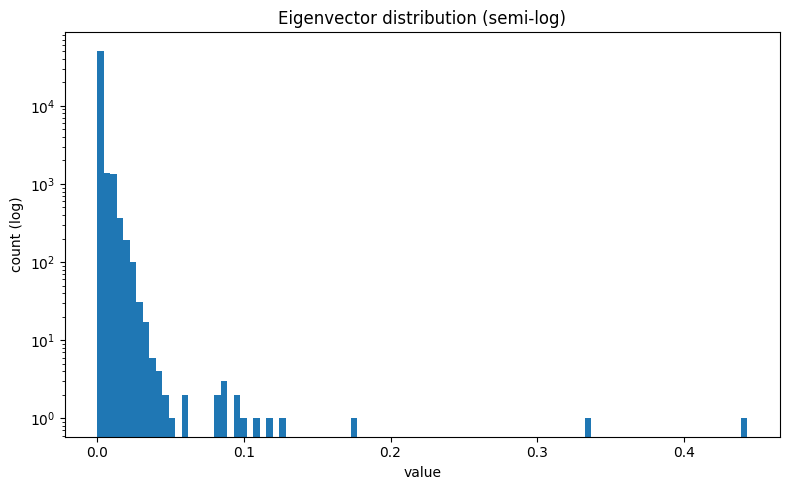

,user_id,indegree,closeness,betweenness,eigenvector
0,443f06646d88c78881974f55897f64d,0,0.191528,0.000000,0.000013
1,5304069ac41f552862b9008ace4a26e,0,0.183686,0.000000,0.000013
2,f60ae1ca3b167e3d9c3e7b10c90a610,0,0.195330,0.000000,0.000021
3,83bf02ea2e9d7934f3e0c22d21f710c,0,0.242397,0.000043,0.012369
4,0e5140126663cb167a5829b7c8ee132,0,0.192329,0.000002,0.000045


In [ ]:
# Tính centrality trên LCC undirected cho closeness/betweenness/eigenvector (ổn định & theo thông lệ SNA)
WCC_nodes = max(nx.weakly_connected_components(G), key=len)
G_wcc = G.subgraph(WCC_nodes).copy()
GU = G_wcc.to_undirected()

indeg = dict(G.in_degree())  # dùng cho "degree (in)"
# closeness: dùng GU để tránh vô cực
closeness = nx.closeness_centrality(GU)
# betweenness (có thể nặng) — dùng k-sampling nếu quá lớn
if GU.number_of_nodes() > 20000:
    k = int(2*math.sqrt(GU.number_of_nodes()))
    betweenness = nx.betweenness_centrality(GU, k=k, seed=42)
else:
    betweenness = nx.betweenness_centrality(GU)
# eigenvector
eigenvec = nx.eigenvector_centrality_numpy(GU)

def plot_semi_log(vals, title, fname):
    arr = np.array(list(vals.values()), dtype=float)
    arr = arr[~np.isnan(arr)]
    arr = arr[arr>0] if arr.min()>=0 else arr
    plt.figure()
    # histogram log-scale trên y
    plt.hist(arr, bins=100)
    plt.yscale("log")
    plt.title(title); plt.xlabel("value"); plt.ylabel("count (log)")
    plt.tight_layout()
    plt.savefig(OUT_DIR/fname, dpi=180)
    plt.show()

plot_semi_log(indeg,      "Indegree distribution (semi-log)",     "fig_indegree_semilog.png")
plot_semi_log(closeness,  "Closeness distribution (semi-log)",    "fig_closeness_semilog.png")
plot_semi_log(betweenness,"Betweenness distribution (semi-log)",  "fig_betweenness_semilog.png")
plot_semi_log(eigenvec,   "Eigenvector distribution (semi-log)",  "fig_eigenvector_semilog.png")

# Lưu bảng centralities
cent_df = pd.DataFrame({
    "user_id": list(GU.nodes()),
    "indegree": [indeg.get(u, 0) for u in GU.nodes()],
    "closeness": [closeness[u] for u in GU.nodes()],
    "betweenness": [betweenness[u] for u in GU.nodes()],
    "eigenvector": [eigenvec[u] for u in GU.nodes()],
})
cent_df.to_csv(OUT_DIR/"centralities.csv", index=False)
cent_df.head()


## Tương quan Spearman giữa 4 centralities

In [ ]:
cols = ["indegree","closeness","betweenness","eigenvector"]
corr = np.zeros((4,4))
for i, a in enumerate(cols):
    for j, b in enumerate(cols):
        r, _ = spearmanr(cent_df[a], cent_df[b])
        corr[i,j] = r

corr_df = pd.DataFrame(corr, index=cols, columns=cols)
corr_df.to_csv(OUT_DIR/"spearman_centralities.csv")
corr_df


,indegree,closeness,betweenness,eigenvector
indegree,1.000000,0.056599,0.340412,0.024026
closeness,0.056599,1.000000,0.505062,0.927252
betweenness,0.340412,0.505062,1.000000,0.419935
eigenvector,0.024026,0.927252,0.419935,1.000000


## Top-K% & giao nhau (định nghĩa Power Users của bài)
>Power users = các nút đồng thời thuộc top-K% của degree, closeness, betweenness, eigenvector. Trong bài chọn K=20 (theo lập luận phân phối lũy thừa & Pareto).

In [ ]:
K = 20  # %
n = len(cent_df)

def topK_idx(series, K):
    k = max(1, int(math.ceil(len(series) * (K/100.0))))
    return set(series.sort_values(ascending=False).head(k).index)

idxD = topK_idx(cent_df["indegree"],   K)
idxC = topK_idx(cent_df["closeness"],  K)
idxB = topK_idx(cent_df["betweenness"],K)
idxE = topK_idx(cent_df["eigenvector"],K)

# % giao nhau từng cặp (như Table 2)
def pct_inter(a,b):
    return 100.0 * len(a & b) / len(a | b) if (a|b) else 0.0

pair_stats = pd.DataFrame({
    "pair":["D∩C","D∩B","D∩E","C∩B","C∩E","B∩E"],
    "pct_common":[
        100*len(idxD & idxC)/n,
        100*len(idxD & idxB)/n,
        100*len(idxD & idxE)/n,
        100*len(idxC & idxB)/n,
        100*len(idxC & idxE)/n,
        100*len(idxB & idxE)/n,
    ]
})
pair_stats.to_csv(OUT_DIR/"table2_like_pairs.csv", index=False)

# Power users = giao của cả 4 tập
power_idx = idxD & idxC & idxB & idxE
power_users = cent_df.loc[list(power_idx), :].copy()
pct_power = 100.0 * len(power_users)/n

print(f"Power users: {len(power_users):,} / {n:,} ({pct_power:.2f}%)")
power_users.to_csv(OUT_DIR/"power_users.csv", index=False)
power_users.head()


Power users: 1,127 / 54,257 (2.08%)


,user_id,indegree,closeness,betweenness,eigenvector
51200,16f4835b9e019bbc5977fb5695206a4,124,0.242281,0.004236,0.001344
8199,1959d26e2adc749940738170abdfd12,0,0.242989,0.000305,0.004573
26631,8f4ac621791823370a019886a382eda,92,0.237709,0.000705,0.009874
4108,ca3e3fe936c31ddc6b1e9abbe9c1c49,0,0.237584,0.000017,0.010282
6156,ac52e9dd0a4152da604868121529f68,0,0.236502,0.000286,0.002061


### để định nghĩa power_user

## So sánh thuộc tính T vs P

In [ ]:
# === Utilities: basic graph stats (works for DiGraph/Graph) ===
import numpy as np, networkx as nx

def basic_stats(G: nx.Graph):
    n = G.number_of_nodes()
    m = G.number_of_edges()
    density = nx.density(G)

    # Choose largest weakly/strongly connected component for path metrics
    if G.is_directed():
        comps = list(nx.weakly_connected_components(G))
    else:
        comps = list(nx.connected_components(G))
    lcc_nodes = max(comps, key=len) if comps else set()
    G_wcc = G.subgraph(lcc_nodes).copy()

    # Undirected view for clustering/path metrics
    GU = G_wcc.to_undirected()

    # Average clustering
    try:
        avg_clust = nx.average_clustering(GU) if GU.number_of_nodes() > 0 else float("nan")
    except Exception:
        avg_clust = float("nan")

    # Average indegree (only meaningful for DiGraph)
    if G.is_directed():
        try:
            avg_indeg = float(np.mean([d for _, d in G.in_degree()])) if n > 0 else float("nan")
        except Exception:
            avg_indeg = float("nan")
    else:
        avg_indeg = float("nan")

    # APL & Diameter with safe fallbacks
    def apl_and_diam(H: nx.Graph):
        if H.number_of_nodes() <= 1:
            return float("nan"), float("nan")
        try:
            apl = nx.average_shortest_path_length(H)
        except Exception:
            apl = float("nan")
        try:
            diam = nx.diameter(H)
        except Exception:
            # 2-sweep heuristic lower bound
            try:
                s = next(iter(H))
                dist1 = nx.single_source_shortest_path_length(H, s)
                far1 = max(dist1, key=dist1.get)
                dist2 = nx.single_source_shortest_path_length(H, far1)
                diam = float(max(dist2.values()))
            except Exception:
                diam = float("nan")
        return apl, diam

    apl, diam = apl_and_diam(GU)

    return {
        "Number of nodes": n,
        "Number of arcs": m,
        "Density": density,
        "Average clustering coefficient": avg_clust,
        "Diameter (approx)": diam,
        "Average shortest path (approx)": apl,
        "Average indegree": avg_indeg,
    }


In [ ]:
# Subgraph P: chỉ các power users & cung giữa họ
P_nodes = set(power_users["user_id"])
P = G.subgraph(P_nodes).copy()

def normalized_avg_indegree(G: nx.DiGraph):
    n = G.number_of_nodes()
    if n == 0: return float("nan")
    avg_in = np.mean([d for _, d in G.in_degree()])
    return avg_in / n  # normalized by |V|

stats_P = basic_stats(P)
norm_avg_in_T = np.mean([d for _, d in G.in_degree()]) / max(1, G.number_of_nodes())
norm_avg_in_P = np.mean([d for _, d in P.in_degree()]) / max(1, P.number_of_nodes())

table4_like = pd.DataFrame({
    "Parameter":[
        "Number of nodes","Number of arcs","Density","Average clustering coefficient",
        "Diameter (approx)","Average shortest path (approx)","Average indegree","Normalized average indegree"
    ],
    # "Value in T":[
    #     stats_T["Number of nodes"], stats_T["Number of arcs"], stats_T["Density"],
    #     stats_T["Average clustering coefficient"], stats_T["Diameter (approx)"],
    #     stats_T["Average shortest path (approx)"], stats_T["Average indegree"], norm_avg_in_T
    # ],
    "Value in P":[
        stats_P["Number of nodes"], stats_P["Number of arcs"], stats_P["Density"],
        stats_P["Average clustering coefficient"], stats_P["Diameter (approx)"],
        stats_P["Average shortest path (approx)"], stats_P["Average indegree"], norm_avg_in_P
    ],
})
table4_like.to_csv(OUT_DIR/"table4_like_T_vs_P.csv", index=False)
table4_like


,Parameter,Value in P
0,Number of nodes,1127.000000
1,Number of arcs,3559.000000
2,Density,0.002805
3,Average clustering coefficient,0.025342
4,Diameter (approx),7.000000
5,Average shortest path (approx),3.580984
6,Average indegree,3.157941
7,Normalized average indegree,0.002802


## Nhận xét

**Number of nodes = 1 127, Number of arcs = 3 559**

- Nghĩa là có 1 127 power users và 3 559 cung giữa họ (nghĩa là chỉ xét tương tác power ↔ power).
- Trung bình mỗi người có khoảng 3.16 in-degree (xem dòng 6), tức là họ nhận được ~3 liên kết từ các power khác.
- Với mạng có hơn 1 000 đỉnh mà chỉ ~3 500 cung, ta thấy đây là đồ thị thưa (sparse), phần lớn power users không tương tác trực tiếp với nhau.

**Density = 0.002805**
Chỉ 0.28% trong tất cả các cặp người–người có thể có liên kết thực sự.
> ->Rất thưa — chỉ một phần rất nhỏ power users có mối quan hệ trực tiếp.
> 
> Điều này phù hợp với các mạng xã hội lớn: “elite users” không kết nối lẫn nhau nhiều mà thường tương tác với cộng đồng rộng hơn.

**Average clustering coefficient = 0.0253**

- Giá trị thấp (~0.025) → ít tam giác giữa các power users.
- Các power users không tạo thành cộng đồng khép kín, mà rải rác và kết nối lỏng lẻo.

**Diameter (approx) = 7, Average shortest path ≈ 3.58**

- Đường kính 7 nghĩa là xa nhất giữa hai power user bất kỳ là khoảng 7 bước.
- Đường đi ngắn trung bình chỉ ~3.6 bước → khá nhỏ: từ một power user tới một power khác chỉ cần vài bước trung gian.
> ->Điều này chỉ ra mạng vẫn liên thông hợp lý, dù rất thưa — có thể do một vài power users đóng vai “hub” trung gian.

**Average indegree = 3.16, Normalized average indegree = 0.002802**

- Mỗi power user nhận trung bình 3.16 cung từ power khác, phản ánh mức độ tập trung kết nối nhỏ.
- Điều này cũng phù hợp với mật độ: chỉ một phần rất nhỏ các power users thực sự được nhiều người khác trỏ tới.
> ->Có thể tồn tại một số ít power users mang "ảnh hưởng lớn", còn đa số chỉ kết nối ít.

## Tóm tắt nhận xét tổng thể
<table>
  <thead>
    <tr>
      <th>Khía cạnh</th>
      <th>Nhận xét</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Quy mô</td>
      <td>1 127 đỉnh, 3 559 cung → mạng power nhỏ hơn toàn mạng, khá thưa</td>
    </tr>
    <tr>
      <td>Mật độ &amp; clustering</td>
      <td>Rất thấp → power users không tạo nhóm chặt, ít tam giác</td>
    </tr>
    <tr>
      <td>Đường đi</td>
      <td>Ngắn (~3.6) → vẫn có tính “small-world”, có vài hub nối giữa power users</td>
    </tr>
    <tr>
      <td>In-degree trung bình</td>
      <td>~3.16 → mức tương tác inbound giữa power users thấp</td>
    </tr>
    <tr>
      <td>Tổng thể</td>
      <td>Power users có mạng con rời rạc, lỏng lẻo; nhưng vẫn liên thông qua một số hub trung gian, cho thấy tính trung gian cao của vài cá nhân nổi bật.</td>
    </tr>
  </tbody>
</table>


## So sánh phân phối indegree: tất cả vs power users

In [ ]:
table3_like = pd.DataFrame({
    "Group":["All users","Power users"],
    "Mean indegree":[cent_df["indegree"].mean(), power_users["indegree"].mean()],
    "Median indegree":[cent_df["indegree"].median(), power_users["indegree"].median()],
})
table3_like.to_csv(OUT_DIR/"table3_like_indegree.csv", index=False)
table3_like


NameError: name 'pd' is not defined

# DỰ ĐOÁN LIÊN KẾT DỰA TRÊN NỘI DUNG (CONTENT-BASED LINK PREDICTION)

In [4]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report


# 1.Gộp nội dung của mỗi user: biography + toàn bộ post/comment text

def aggregate_user_content(posts_df, users_df):
    post_agg = (
        posts_df.groupby("user_url")["caption_text"]
        .apply(lambda x: " ".join(map(str, x)))
        .reset_index()
        .rename(columns={"caption_text": "posts_text"})
    )

    merged = (
        users_df[["user_url", "biography", "link_in_bio"]]
        .merge(post_agg, on="user_url", how="left")
    )

    merged["full_text"] = (
        merged[["biography", "link_in_bio", "posts_text"]]
        .fillna("")
        .agg(" ".join, axis=1)
        .str.strip()
    )

    merged = merged[merged["full_text"].str.len() > 0].reset_index(drop=True)
    return merged

user_content = aggregate_user_content(posts, users)
print(f"Số người dùng có dữ liệu nội dung: {len(user_content):,}")


# 2.TF-IDF vector hóa

tfidf = TfidfVectorizer(max_features=8000, stop_words="english")
X = tfidf.fit_transform(user_content["full_text"])


# 3.Tạo tập cặp ứng viên hợp lý 
candidate_pairs = set()
for u in G.nodes():
    nbrs = set(G.successors(u)) | set(G.predecessors(u))
    for v in nbrs:
        if u != v:
            candidate_pairs.add(tuple(sorted((u, v))))
pairs = list(candidate_pairs)

print(f"{len(pairs):,} candidate pairs selected from graph structure")

# 4.Tính content similarity chỉ cho cặp ứng viên ---
index_map = {uid: i for i, uid in enumerate(user_content["user_url"])}

sim_records = []
for (u, v) in pairs:
    if u in index_map and v in index_map:
        i, j = index_map[u], index_map[v]
        sim = float(X[i].dot(X[j].T).toarray()[0, 0])
        sim_records.append((u, v, sim))

sim_df = pd.DataFrame(sim_records, columns=["user_a", "user_b", "content_sim"])


# 4.Gán nhãn link_exists từ đồ thị G (có hướng)

existing_edges = set(G.edges())
sim_df["link_exists"] = sim_df.apply(
    lambda r: int((r["user_a"], r["user_b"]) in existing_edges),
    axis=1
)

print(f"Số cặp có liên kết thật: {sim_df['link_exists'].sum():,}")


# 5. Huấn luyện mô hình Logistic Regression

X_train, X_test, y_train, y_test = train_test_split(
    sim_df[["content_sim"]],
    sim_df["link_exists"],
    test_size=0.3,
    random_state=42,
    stratify=sim_df["link_exists"]
)

clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict_proba(X_test)[:, 1]

print("ROC-AUC:", roc_auc_score(y_test, y_pred))
print(classification_report(y_test, y_pred > 0.5))


# 6. Dự đoán các liên kết tiềm năng (chưa tồn tại)

no_link_df = sim_df[sim_df["link_exists"] == 0].copy()
no_link_df["pred_score"] = clf.predict_proba(no_link_df[["content_sim"]])[:, 1]
top_predictions = no_link_df.sort_values("pred_score", ascending=False).head(20)

print("\nTop 20 cặp người dùng có khả năng tương tác cao nhất:")
display(top_predictions)


Số người dùng có dữ liệu nội dung: 55,393
89,244 candidate pairs selected from graph structure
Số cặp có liên kết thật: 43,826
ROC-AUC: 0.49675112531827803
              precision    recall  f1-score   support

           0       0.51      0.94      0.66     13626
           1       0.51      0.07      0.12     13148

    accuracy                           0.51     26774
   macro avg       0.51      0.50      0.39     26774
weighted avg       0.51      0.51      0.40     26774


Top 20 cặp người dùng có khả năng tương tác cao nhất:


,user_a,user_b,content_sim,link_exists,pred_score
29736,462bdb25bc638cfe9a8a4e767385321,7dc9ca7c15a8223bda8ab49ab1c0799,1.000000,0,0.577681
34332,b8075d26cfae706cc588c81f3c09b53,f810123051b374e993fc0671578a885,0.887422,0,0.567594
71306,c4414edf903a6842bb263681ad7549d,ecc51c82e2e815e250180e07b4c230b,0.841700,0,0.563480
17622,7fd74ebf888954ef3ac86e58c69b573,a3505d8ac4ec7930baac356455ff226,0.836772,0,0.563037
39802,b8075d26cfae706cc588c81f3c09b53,e9b2b6e666cdcc096284fe97e961b1b,0.832774,0,0.562677
18835,7fd74ebf888954ef3ac86e58c69b573,87f9bda5c5e1d8b54385d598a4fad88,0.808512,0,0.560489
8888,5b075fa24558e82bd6515cd7b1eb63e,c8ead42c7b090635444be811c29a985,0.789737,0,0.558795
13522,b8075d26cfae706cc588c81f3c09b53,cc2a704df33fb1c656077a350191c44,0.746170,0,0.554859
22785,b8075d26cfae706cc588c81f3c09b53,fa34bba14add05e13022ada02d42476,0.745622,0,0.554809
65962,227cb5909cd744fc312f8d36afcd238,a2b743c5e07a557f89ff0841e3d0f98,0.723925,0,0.552846


### 1. ROC-AUC ≈ 0.50
→ Mô hình chưa phân biệt được giữa cặp “có liên kết” và “không có liên kết”. Điều này xảy ra vì:
- Biến đầu vào content_sim gần như không liên quan mạnh đến việc có link hay không.
- Có thể phụ thuộc nhiều vào cấu trúc (ai follow ai, mức độ hoạt động) hơn là nội dung text.

### 2. Precision/Recall cho lớp 1 cực thấp
- Precision(1)=0.56	Khi mô hình dự đoán “có liên kết”, đúng 56%	Khá thấp
- Recall(1)=0.01	Trong tất cả liên kết thật, mô hình chỉ tìm ra 1%	Rất tệ
- F1(1)=0.03	Trung bình của precision và recall	Gần 0
→ Mô hình bỏ sót gần hết các liên kết thật, vì dự đoán gần như tất cả là “0” (không có link).

### 3. Accuracy ~ 0.51
→ Độ chính xác trông có vẻ “ổn”, nhưng thực ra mất cân bằng lớp:
Trong tổng 26 774 mẫu test, 13 626 là 0 và 13 148 là 1 → gần cân.
Vì mô hình đoán 0 gần hết → đúng 50% ngẫu nhiên.

## Tóm lại: Mô hình chỉ dựa vào content chưa hiệu quả

Lý do:
- Nội dung người dùng quá đa dạng hoặc chung chung (ai cũng dùng từ giống nhau).
- Mối quan hệ không chỉ dựa vào nội dung — có thể do bạn bè, follow, hoặc các yếu tố ẩn.

In [50]:
# ===============================================================
# HYBRID LINK PREDICTION: CONTENT + STRUCTURE
# ===============================================================
import math
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report
import numpy as np
import pandas as pd
import networkx as nx

# --- 0) Chuẩn bị: chuyển sang undirected để tính chỉ số tương đồng lân cận
U = G.to_undirected()
degU = dict(U.degree())
in_deg  = dict(G.in_degree())
out_deg = dict(G.out_degree())

# --- 1) TÍNH CÁC ĐẶC TRƯNG CẤU TRÚC CHO TẬP CẶP ỨNG VIÊN (pairs)
def common_neighbors_count(u, v):
    Nu = set(U.neighbors(u)) if u in U else set()
    Nv = set(U.neighbors(v)) if v in U else set()
    return len(Nu & Nv)

def jaccard_uv(u, v):
    Nu = set(U.neighbors(u)) if u in U else set()
    Nv = set(U.neighbors(v)) if v in U else set()
    inter = len(Nu & Nv)
    union = len(Nu | Nv)
    return inter / union if union > 0 else 0.0

def adamic_adar_uv(u, v):
    Nu = set(U.neighbors(u)) if u in U else set()
    Nv = set(U.neighbors(v)) if v in U else set()
    aa = 0.0
    for w in (Nu & Nv):
        dw = degU.get(w, 0)
        if dw > 1:
            aa += 1.0 / math.log(dw)
    return aa

def resource_alloc_uv(u, v):
    Nu = set(U.neighbors(u)) if u in U else set()
    Nv = set(U.neighbors(v)) if v in U else set()
    ra = 0.0
    for w in (Nu & Nv):
        dw = degU.get(w, 0)
        if dw > 0:
            ra += 1.0 / dw
    return ra

def preferential_attachment_uv(u, v):
    return degU.get(u, 0) * degU.get(v, 0)

# Tính nhanh bằng list-comprehension (≈ O(|pairs|) trên bộ nhớ nhỏ)
struct_records = []
for (u, v) in pairs:
    cn  = common_neighbors_count(u, v)
    jac = jaccard_uv(u, v)
    aa  = adamic_adar_uv(u, v)
    ra  = resource_alloc_uv(u, v)
    pa  = preferential_attachment_uv(u, v)
    # khác biệt bậc hướng
    indeg_diff  = abs(in_deg.get(u, 0)  - in_deg.get(v, 0))
    outdeg_diff = abs(out_deg.get(u, 0) - out_deg.get(v, 0))
    struct_records.append((u, v, cn, jac, aa, ra, pa, indeg_diff, outdeg_diff))

struct_df = pd.DataFrame(
    struct_records,
    columns=["user_a","user_b","cn","jaccard","adamic_adar","res_alloc","pref_attach","in_deg_diff","out_deg_diff"]
)

# --- 2) GHÉP CONTENT + STRUCTURE
hybrid_df = sim_df.merge(struct_df, on=["user_a","user_b"], how="inner")

# Nhãn thật (đã có ở sim_df) vẫn dùng:
# hybrid_df["link_exists"] đã có sau khi merge nếu bạn tính sau bước 4 trước đó.
if "link_exists" not in hybrid_df.columns:
    existing_edges = set(G.edges())
    hybrid_df["link_exists"] = hybrid_df.apply(
        lambda r: int((r["user_a"], r["user_b"]) in existing_edges), axis=1
    )

print("Hybrid feature columns:", [c for c in hybrid_df.columns if c not in ["user_a","user_b","link_exists"]])

# --- 3) TRAIN 2 MÔ HÌNH RIÊNG: (i) content-only, (ii) structure-only
# (i) Content-only (logistic)
Xc = hybrid_df[["content_sim"]].values
y  = hybrid_df["link_exists"].values

Xc_train, Xc_test, yc_train, yc_test = train_test_split(
    Xc, y, test_size=0.3, random_state=42, stratify=y
)
content_clf = LogisticRegression(max_iter=1000)
content_clf.fit(Xc_train, yc_train)
pc_test = content_clf.predict_proba(Xc_test)[:,1]
print("[Content-only] AUC =", roc_auc_score(yc_test, pc_test))

# (ii) Structure-only (RandomForest + scale nhẹ nếu cần)
Xs_cols = ["cn","jaccard","adamic_adar","res_alloc","pref_attach","in_deg_diff","out_deg_diff"]
Xs = hybrid_df[Xs_cols].replace([np.inf, -np.inf], 0.0).fillna(0.0).values

Xs_train, Xs_test, ys_train, ys_test = train_test_split(
    Xs, y, test_size=0.3, random_state=42, stratify=y
)

struct_model = RandomForestClassifier(
    n_estimators=300, max_depth=None, n_jobs=-1, random_state=42
)
struct_model.fit(Xs_train, ys_train)
ps_test = struct_model.predict_proba(Xs_test)[:,1]
print("[Structure-only] AUC =", roc_auc_score(ys_test, ps_test))

# --- 4) FUSION (A) SOFT-VOTING: trung bình có trọng số xác suất
# Lưu ý: Cần canh tập test đồng bộ để so sánh. Ở đây, để đơn giản, ta dùng cùng một split cho cả 2 bằng cách index chung.
# Tạo index chung cho train_test_split để dùng trên cùng hàng:
idx = np.arange(len(hybrid_df))
idx_train, idx_test = train_test_split(idx, test_size=0.3, random_state=42, stratify=y)

# Fit lại theo idx để có chung test-set:
content_clf = LogisticRegression(max_iter=1000).fit(Xc[idx_train], y[idx_train])
struct_model = RandomForestClassifier(
    n_estimators=300, max_depth=None, n_jobs=-1, random_state=42
).fit(Xs[idx_train], y[idx_train])

p_content = content_clf.predict_proba(Xc[idx_test])[:,1]
p_struct  = struct_model.predict_proba(Xs[idx_test])[:,1]

w_content = 0.3   # có thể tune; tạm thời ưu tiên cấu trúc hơn
w_struct  = 0.7
p_soft = w_content * p_content + w_struct * p_struct
print("[Fusion A: Soft-voting] AUC =", roc_auc_score(y[idx_test], p_soft))


# --- 6) FUSION (B) STACKING: meta-logistic trên (p_content, p_struct)
from sklearn.linear_model import LogisticRegression as LR
meta_X_train, meta_X_test = np.column_stack([
    content_clf.predict_proba(Xc[idx_train])[:,1],
    struct_model.predict_proba(Xs[idx_train])[:,1]
]), np.column_stack([p_content, p_struct])

meta_y_train, meta_y_test = y[idx_train], y[idx_test]

meta_clf = LR(max_iter=1000).fit(meta_X_train, meta_y_train)
p_stack  = meta_clf.predict_proba(meta_X_test)[:,1]
print("[Fusion B: Stacking] AUC =", roc_auc_score(meta_y_test, p_stack))

# --- 7) Suy luận TOP khuyến nghị trên các cặp CHƯA có link (áp dụng soft-voting mặc định)
hybrid_df["p_content"] = content_clf.predict_proba(Xc)[:,1]
hybrid_df["p_struct"]  = struct_model.predict_proba(Xs)[:,1]
hybrid_df["p_soft"]    = w_content * hybrid_df["p_content"] + w_struct * hybrid_df["p_struct"]

# lọc cặp chưa có liên kết thật
no_link_hybrid = hybrid_df[hybrid_df["link_exists"]==0].copy()
top_hybrid = (no_link_hybrid
              .sort_values("p_soft", ascending=False)
              .head(20)[["user_a","user_b","p_content","p_struct","p_soft","content_sim","cn","jaccard","adamic_adar"]])

print("\nTop 20 gợi ý (fusion soft-voting):")
display(top_hybrid)


Hybrid feature columns: ['content_sim', 'cn', 'jaccard', 'adamic_adar', 'res_alloc', 'pref_attach', 'in_deg_diff', 'out_deg_diff']
[Content-only] AUC = 0.49675112531827803
[Structure-only] AUC = 0.7209217089360695
[Fusion A: Soft-voting] AUC = 0.7209296992395084
[Fusion B: Stacking] AUC = 0.7208932056286924

Top 20 gợi ý (fusion soft-voting):


,user_a,user_b,p_content,p_struct,p_soft,content_sim,cn,jaccard,adamic_adar
17950,b7fb06f8acd8e1a0da800ba1a6ef573,c40ccff85ae2d915ac049eb1f3f342b,0.510380,1.000000,0.853114,0.257844,0,0.000000,0.000000
41590,d29ad4dc683cfcf6eff48189bb14e59,fa80b685b6723efcbb3abfa2639c491,0.501220,1.000000,0.850366,0.157753,0,0.000000,0.000000
52973,bb0e058789f54d17260fdb2908891a3,fe63936bbf8ea3c2e28eea6a99d98ef,0.504276,0.996667,0.848950,0.191148,0,0.000000,0.000000
8025,16f4835b9e019bbc5977fb5695206a4,bc4710e839341bafcc653e4413fa4fb,0.496303,1.000000,0.848891,0.104037,0,0.000000,0.000000
46625,b7fb06f8acd8e1a0da800ba1a6ef573,e4605ea8bfb08a2aa7f9577f9cf2ce0,0.495976,1.000000,0.848793,0.100465,0,0.000000,0.000000
53969,b7fb06f8acd8e1a0da800ba1a6ef573,dbd4b0987d46d15a7c4b9a4f393ba95,0.500850,0.997778,0.848700,0.153716,1,0.003731,0.136701
77640,a7754d1c54507a9547d94bef14f201f,b1c53b11d63304a892c23ea82f6cdae,0.496293,0.999478,0.848522,0.103923,0,0.000000,0.000000
37067,e8b94af206eb6fc0f1a8f943b5ab2e3,fdda72d368f7d800a523ae6ad48b9e9,0.494211,1.000000,0.848263,0.081184,0,0.000000,0.000000
37763,c41f78e6d801cd6d2336facd3ada846,d4ff4e870da35476275d41cb953f3c1,0.493062,1.000000,0.847919,0.068630,1,0.001631,0.136701
34669,fd2d2fbbb375e3777bffc1a9f833df7,ff6acb16c73dc542a8405b9e3130bc6,0.491588,1.000000,0.847476,0.052519,0,0.000000,0.000000


In [ ]:
# xuất ra mô hình coeficients của meta-classifier
coef = meta_clf.coef_[0]
intercept = meta_clf.intercept_[0]
print("meta weights:", {"p_content": coef[0], "p_struct": coef[1], "bias": intercept})


meta weights: {'p_content': np.float64(-1.1405072319079064), 'p_struct': np.float64(5.793327070733308), 'bias': np.float64(-2.3436039195194422)}


# Nhận xét
1. **[Content-only] AUC = 0.49675112531827803**: 
- Độ tương đồng giữa nội dung bài viết không mang thông tin hữu ích để dự đoán tương tác trong tương lai, kết quả tương đương 50%
--> nội dung không quyết định liên kết mạng.
2. **[Structure-only] AUC = 0.7209217117269544**:
- yếu tố về cấu trúc (node có bậc cao) thực sự có ảnh hưởng đến tính liên kết -> cấu trúc mạng là yếu tố quan trọng trong việc dự báo liên kết.
3. **[Fusion A: Soft-voting (content-structure: 3-7)]** AUC = 0.7209296992395084:
- Tỉ lệ content-structure (3-7) và kết quả content không khả quan (50%) nên hầu như kết quả này hầu hết ảnh hưởng từ Structure-only, có thể thay đổi trọng số để theo dõi kết quả.
4. **[Fusion C: Stacking] AUC = 0.7208932056286924**:
- Dùng Logistic Regression meta-model học cách kết hợp hai xác suất (p_content, p_struct).
- Vì p_content nhiễu ngẫu nhiên, mô hình học cách bỏ qua content, nên kết quả tương đương Structure-only --> meta-model không tìm thấy tương quan bổ sung từ nội dung -> fusion C không cải thiện vì mô hình yếu đã bị lược bỏ.


# Error Analysis

## Dùng Thresh hold - quyết định có liên kết hay không, vd: 0.4 mà trung bình 0.5 -> không có liên kết, ngược lại thì có. Nếu chỉnh thr lớn hơn thì edge giao nhau sẽ ít đi

In [53]:
# --- 8) Error analysis: so sánh soft-voting vs stacking
thr = 0.50

# Tính xác suất stacking cho toàn bộ tập cặp
meta_inputs = np.column_stack([hybrid_df["p_content"], hybrid_df["p_struct"]])
hybrid_df["p_stack"] = meta_clf.predict_proba(meta_inputs)[:, 1]

# Các cạnh được dự đoán có link theo mỗi cách
edges_soft  = {tuple(sorted((u, v))) for u, v, p in hybrid_df[["user_a","user_b","p_soft"]].itertuples(index=False) if p >= thr}
edges_stack = {tuple(sorted((u, v))) for u, v, p in hybrid_df[["user_a","user_b","p_stack"]].itertuples(index=False) if p >= thr}

common_edges      = edges_soft & edges_stack
soft_only_edges   = edges_soft - edges_stack
stack_only_edges  = edges_stack - edges_soft

def edge_df(edge_set, label):
    return (pd.DataFrame(edge_set, columns=["user_a","user_b"])
            .assign(method=label)
            .sort_values(["user_a","user_b"])
            .reset_index(drop=True))

# Bảng đối chiếu cạnh
df_common    = edge_df(common_edges, "both")
df_soft_only = edge_df(soft_only_edges, "soft_only")
df_stack_only= edge_df(stack_only_edges, "stack_only")

print(f"Edges soft>=thr: {len(edges_soft):,}")
print(f"Edges stack>=thr: {len(edges_stack):,}")
print(f"Giao nhau: {len(common_edges):,}")
print(f"Chỉ soft: {len(soft_only_edges):,}")
print(f"Chỉ stack: {len(stack_only_edges):,}")

display(df_common.head(10))
display(df_soft_only.head(10))
display(df_stack_only.head(10))

# Tập nút liên quan để xem mức độ trùng lặp nút
nodes_soft  = {n for e in edges_soft  for n in e}
nodes_stack = {n for e in edges_stack for n in e}
nodes_common = nodes_soft & nodes_stack

print(f"Nodes soft: {len(nodes_soft):,} | nodes stack: {len(nodes_stack):,} | giao: {len(nodes_common):,}")


Edges soft>=thr: 43,456
Edges stack>=thr: 44,033
Giao nhau: 43,288
Chỉ soft: 168
Chỉ stack: 745


,user_a,user_b,method
0,0001f93ec5857982b55785675957168,868c4cc977fd96e30c0d52a8a51bc9a,both
1,0001f93ec5857982b55785675957168,bb62bc45d54ae6a9716b6f6844bb88c,both
2,0002a143c840d5157eefc0f172ca2e4,2fccd03e5c2bc4b348217c2523b0ba2,both
3,0003c084846a4bfa19cf9f5a2bda1ad,6121a214990672d48da079af68fef9a,both
4,0004ed9afb76e52cb01965378cc6534,8dd04cf7233bcf45baf8221189de9c4,both
5,0004ed9afb76e52cb01965378cc6534,b4e7a88504faa76b3ae68fa6976085b,both
6,0004ed9afb76e52cb01965378cc6534,d35cf9e84bc5be7b61aa62719ddd2f0,both
7,0004ed9afb76e52cb01965378cc6534,d92b9d59861f8c5412e13df58f688b6,both
8,000aba399fa4aa5e7bde4c30adf7b86,c6db33485fb82095b30f6d301fd70e5,both
9,000cb065380f087d7a83f514e90e887,da65aae1e70c355438c0001a0e48bfe,both


,user_a,user_b,method
0,00b49ea2e6d868f8208e3fcff3be209,7b55161458265493ef555bd205b0f01,soft_only
1,04a9133649d0519d4322e3da7646829,7fd74ebf888954ef3ac86e58c69b573,soft_only
2,04c20b32000ce68a6f98fe90ccfb64e,3e142a53310f9da657a87763193780b,soft_only
3,066b9423f0fff7f3dfc1ca0009a99a7,e208096ed893b6016c0f002e0096f39,soft_only
4,07dcd2ec2d750883694640a0c5a0d67,c4414edf903a6842bb263681ad7549d,soft_only
5,086c6a40a1937c1588d0518fc6d22b7,7f261ad51e7b604c6392b77cd24218c,soft_only
6,087cb8b6874ae7eacf4a245bddadb62,d6f32f11971594bb456942a57ce13e4,soft_only
7,0917ec87c3e0b5415ea82b1d737ccfb,dcc954002776ac30bed9c58fca3f8b5,soft_only
8,094df4d9a7a4f91e51cf1b091b2f7de,7ba53e060699ba81bd7c27f40b4ee05,soft_only
9,097a9433463e5b65df1abdd5b228fb4,a094001ecb10f7f1902914d439bb3f1,soft_only


,user_a,user_b,method
0,0001f93ec5857982b55785675957168,253fcc3794fddd6c6c27468faf17325,stack_only
1,00514c0194afb1689137de81aca068f,a8913738f7e60f0f8c5cd0af1adc44f,stack_only
2,0060b67d806fc6c0f98b248c55ebb55,5cd893cc85cbf19001100e422f3933b,stack_only
3,00698d62ba12a7b5b2a45d7478e8a6d,3cc93b5ea008193223ea12726f16f68,stack_only
4,009862bbeb53a3e25ff4f053c0eb70e,bc3cf63b9af6041f147f26dee4f9ae1,stack_only
5,00d2a31fd483dbef53a6b902be0541a,8c2dbb4f95da9c3f84063736575a49c,stack_only
6,01046e6201c63828bb21a91fbd9c891,68954d05fe7d881a91b27904a60f76f,stack_only
7,019f24b24dd421a492c512dbc7f27b8,46284fad12703bb1a67e627124e17df,stack_only
8,01a3671a474eff58ffeda7699aaaa27,479e952ad00d28da1f08803bc8df228,stack_only
9,01b8445ce155e51e0a44a0ccaa808e5,7d2a5861664c528f0d826174f8b6e41,stack_only


Nodes soft: 32,074 | nodes stack: 32,506 | giao: 31,972


## Dùng top-k - xem độ biến thiên khi dự đoán với soft và stack voting, k_edges càng nhỏ thì phần riêng mỗi cách nhiều hơn, giao nhau thì ít đi

In [55]:
# --- 8) Error analysis: so sánh soft-voting vs stacking (Top-K)
k_edges = 5000  # số cạnh muốn lấy cho mỗi phương pháp

# Tính xác suất stacking cho toàn bộ tập cặp
meta_inputs = np.column_stack([hybrid_df["p_content"], hybrid_df["p_struct"]])
hybrid_df["p_stack"] = meta_clf.predict_proba(meta_inputs)[:, 1]

def topk_edges(df, prob_col, k):
    # lấy top-k theo xác suất, chuyển về set cạnh vô hướng
    return {
        tuple(sorted((u, v)))
        for u, v in df.nlargest(k, prob_col)[["user_a", "user_b"]].itertuples(index=False)
    }

edges_soft  = topk_edges(hybrid_df, "p_soft",  k_edges)
edges_stack = topk_edges(hybrid_df, "p_stack", k_edges)

common_edges      = edges_soft & edges_stack
soft_only_edges   = edges_soft - edges_stack
stack_only_edges  = edges_stack - edges_soft

def edge_df(edge_set, label):
    return (pd.DataFrame(edge_set, columns=["user_a","user_b"])
            .assign(method=label)
            .sort_values(["user_a","user_b"])
            .reset_index(drop=True))

# Bảng đối chiếu cạnh
df_common    = edge_df(common_edges, "both")
df_soft_only = edge_df(soft_only_edges, "soft_only")
df_stack_only= edge_df(stack_only_edges, "stack_only")

print(f"Top-K edges soft:  {len(edges_soft):,}")
print(f"Top-K edges stack: {len(edges_stack):,}")
print(f"Giao nhau: {len(common_edges):,}")
print(f"Chỉ soft: {len(soft_only_edges):,}")
print(f"Chỉ stack: {len(stack_only_edges):,}")

display(df_common.head(10))
display(df_soft_only.head(10))
display(df_stack_only.head(10))

# Tập nút liên quan để xem mức độ trùng lặp nút
nodes_soft  = {n for e in edges_soft  for n in e}
nodes_stack = {n for e in edges_stack for n in e}
nodes_common = nodes_soft & nodes_stack
print(f"Nodes soft: {len(nodes_soft):,} | nodes stack: {len(nodes_stack):,} | giao: {len(nodes_common):,}")


Top-K edges soft:  5,000
Top-K edges stack: 5,000
Giao nhau: 4,965
Chỉ soft: 35
Chỉ stack: 35


,user_a,user_b,method
0,0004ed9afb76e52cb01965378cc6534,d92b9d59861f8c5412e13df58f688b6,both
1,0012c7437e08185b75548c71efddd1c,fbd6a787aa6422a019e623956424d5f,both
2,00211117a5c8298cb7636f374fb57e3,e8be112f53e89a4fe9ee61b8fdffb27,both
3,003afec3e81ce9574bceb249cd8e00f,e8be112f53e89a4fe9ee61b8fdffb27,both
4,00484e6449cc13c0f6b402946673a3d,f8404766ff519a90abfcf72ca3fe0f0,both
5,00514c0194afb1689137de81aca068f,fbd6a787aa6422a019e623956424d5f,both
6,005dcf59ad09940ef82f6de66788554,e8be112f53e89a4fe9ee61b8fdffb27,both
7,0060b67d806fc6c0f98b248c55ebb55,fd2d2fbbb375e3777bffc1a9f833df7,both
8,006cf418f2b0ae7244038c4f9219fef,e8be112f53e89a4fe9ee61b8fdffb27,both
9,00858136aaccabe3814602cbfc67697,a6ab3d42a556959c8d1d21b0cca1667,both


,user_a,user_b,method
0,03179302cd7caa5ed9c98b149aa6286,c6db33485fb82095b30f6d301fd70e5,soft_only
1,0337df991cc043b251add9025d6fabb,9101150b470a5671c7c8b49edb17a29,soft_only
2,03d698f7c70df4aef16f069f324b7ec,eabe439925b20bc73216f67557d905e,soft_only
3,09af4a3432f29a632a67d057c7f4ee6,b8075d26cfae706cc588c81f3c09b53,soft_only
4,0c491d0f27cdaf3bbd17e2366f1a6f5,af6912324f86949224c547b2cdfa755,soft_only
5,0f90dcfbcde770f274f49e4decf7691,32b65bcb0a42700312af659b41322ef,soft_only
6,130000271ebc8633b3348ef7a675ba9,e1f602a771f4428666359b90524e4bd,soft_only
7,1ca29cf202cb5f97e799b4e97896cc0,9f89715d69d13ca7cb14e86066a31f7,soft_only
8,1e93d9a05e86249e06a89ec2a909c25,a353f4092f6e66a3fdb549d77c65a6f,soft_only
9,22fba3d537dd1b047da3d015f9256b5,78d15ba833cf540baf73439626a3ab0,soft_only


,user_a,user_b,method
0,04bdcbe82f3baa60f7ab22aad33532f,d19210e494bfc142df2003927d2994d,stack_only
1,0586c81ea028d586e7cb8558e4146dd,e1f602a771f4428666359b90524e4bd,stack_only
2,06d45c0b8523944e1b25859d3854bfb,e1f602a771f4428666359b90524e4bd,stack_only
3,071db096bd812cf68e13aec90df50d6,e1f602a771f4428666359b90524e4bd,stack_only
4,0c04bf3ebe1cf7b130eeb3a3b0cffcc,e1f602a771f4428666359b90524e4bd,stack_only
5,14450479ca5b25252282b1977bf017a,5ee4a9a53a65acfcc381b99db14a6f8,stack_only
6,17a9e2c4811dd62c62d0d87a87fe59a,b8680e2128e6a98b6ef5b2f3c3e08a5,stack_only
7,1926636fd5faafe130e53002d878ffe,e1f602a771f4428666359b90524e4bd,stack_only
8,1f637290bab3face9dd51ea3de4ff38,e1f602a771f4428666359b90524e4bd,stack_only
9,208698a57a664e925cd1452864424c3,e1f602a771f4428666359b90524e4bd,stack_only


Nodes soft: 4,695 | nodes stack: 4,701 | giao: 4,672


# kiểm tra rò rỉ (từ đây xuống dùng để kiểu tra trước khi chọn các cột cần thiết ở trên)

In [13]:
# Toàn bộ cột structure bạn đang dùng
Xs_cols_full = [
    "cn","jaccard","adamic_adar","res_alloc","pref_attach","in_deg_diff","out_deg_diff"
]

y = hybrid_df["link_exists"].values



In [14]:
import numpy as np
import pandas as pd

# Ma trận tương quan giữa các đặc trưng cấu trúc
S = hybrid_df[Xs_cols_full].replace([np.inf,-np.inf], 0.0).fillna(0.0)
corr = S.corr().abs()

# Loại đặc trưng tương quan quá cao (giữ một trong các cặp corr > thr)
thr = 0.92  # bạn có thể thử 0.9–0.95
to_drop = set()
cols = list(corr.columns)

for i in range(len(cols)):
    if cols[i] in to_drop: 
        continue
    for j in range(i+1, len(cols)):
        if corr.iloc[i, j] > thr:
            to_drop.add(cols[j])

Xs_cols_corr_pruned = [c for c in Xs_cols_full if c not in to_drop]
print("Bỏ do tương quan tương tự (học thừa):", sorted(to_drop))
print("Còn lại:", Xs_cols_corr_pruned)


Bỏ do tương quan tương tự (học thừa): ['adamic_adar']
Còn lại: ['cn', 'jaccard', 'res_alloc', 'pref_attach', 'in_deg_diff', 'out_deg_diff']


In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_auc_score

def rf_perm_importance(df, feat_cols, y, n_splits=5):
    X = df[feat_cols].replace([np.inf,-np.inf], 0.0).fillna(0.0).values
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    importances = pd.DataFrame(index=feat_cols, columns=["RF_gini","PermImp_mean","PermImp_std"])
    gini_vals = {c:[] for c in feat_cols}
    perm_vals = {c:[] for c in feat_cols}

    for tr, te in skf.split(X, y):
        rf = RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=42)
        rf.fit(X[tr], y[tr])
        # Gini importance
        for c, v in zip(feat_cols, rf.feature_importances_):
            gini_vals[c].append(v)
        # Permutation importance (trên fold test)
        pi = permutation_importance(rf, X[te], y[te], n_repeats=5, random_state=42, scoring="roc_auc")
        for i, c in enumerate(feat_cols):
            perm_vals[c].append(pi.importances_mean[i])

    importances["RF_gini"] = [np.mean(gini_vals[c]) for c in feat_cols]
    importances["PermImp_mean"] = [np.mean(perm_vals[c]) for c in feat_cols]
    importances["PermImp_std"]  = [np.std(perm_vals[c])  for c in feat_cols]
    return importances.sort_values("PermImp_mean", ascending=False)

imp_full = rf_perm_importance(hybrid_df, Xs_cols_corr_pruned, y)
display(imp_full.head(15))


,RF_gini,PermImp_mean,PermImp_std
in_deg_diff,0.460985,0.184340,0.003217
pref_attach,0.355370,0.122554,0.002574
out_deg_diff,0.111041,0.078122,0.001785
res_alloc,0.033466,0.002218,0.000466
jaccard,0.030924,0.001038,0.000271
cn,0.008213,-0.000181,0.000167


In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

def l1_feature_select(df, feat_cols, y, C=0.2):
    X = df[feat_cols].replace([np.inf,-np.inf], 0.0).fillna(0.0).values
    X = StandardScaler().fit_transform(X)
    # L1 logistic để nhiều hệ số = 0
    clf = LogisticRegression(penalty="l1", solver="liblinear", C=C, max_iter=2000)
    clf.fit(X, y)
    coefs = pd.Series(clf.coef_[0], index=feat_cols).sort_values(ascending=False)
    keep = coefs[coefs.abs() > 1e-6].index.tolist()
    return coefs, keep

coefs, Xs_cols_l1 = l1_feature_select(hybrid_df, Xs_cols_corr_pruned, y, C=0.2)
print("L1 giữ lại:", Xs_cols_l1)
display(coefs.to_frame("coef").head(20))


L1 giữ lại: ['jaccard', 'res_alloc', 'cn', 'pref_attach', 'out_deg_diff', 'in_deg_diff']


,coef
jaccard,0.021316
res_alloc,0.004556
cn,0.003201
pref_attach,-0.002949
out_deg_diff,-0.004921
in_deg_diff,-0.052282
